In [32]:
import os, sys, inspect, time
# This example requires theano & lasagne
import theano
import theano.tensor as T
import lasagne
import numpy as np

from mince.database_builder import HDF5ClassDatabaseBuilder
from mince.database_reader import HDF5DatabaseReader
from mince.multiprocess import MultiProcessor
from mince.augmentations import rot_zoom_crop, mult_rgb
from mince.networks import resnet_50

mean = np.load("/data/data/food-101-train.npy")

def process(images, labels):
    # Crop randomly
    w = 224
    h = 224
    
    # Convert
    images = images.astype(theano.config.floatX).copy()
    images_cropped = np.zeros((images.shape[0],images.shape[1], h,w),dtype=theano.config.floatX)
    for i in range(images.shape[0]):
        p = np.random.randint(1)
        if p == 1:
            images[i] = images[i,:,::-1]
        
        # Rotate
        angle = np.random.randint(-10, 10)
        images[i] = rot_zoom_crop(images[i],angle, 1)
        
        # Random color
        r = np.random.randint(800,1200) / 1000.
        g = np.random.randint(800,1200) / 1000.
        b = np.random.randint(800,1200) / 1000.
        images[i] = mult_rgb(images[i], (r,g,b)).clip(0,255)
        
        # Sub mean    
        images[i] -= mean
        
        # Crop
        cy = np.random.randint(0, 32)
        cx = np.random.randint(0, 32)
        images_cropped[i] = images[i,:,cy:cy+h,cx:cx+w]
    
    return images_cropped, labels


"""
Mince part
"""
print "Building and reading database"

# Target db location prefix
db = '/data/data/food-101'

# Folder holding subfolders, one for each class
folder = '/nas/01_Datasets/Food/food-101/images'

# Use helper to parse the folder
classes = HDF5ClassDatabaseBuilder.parse_folder(folder)
n_classes = len(classes)

# Build a db from a set of images
# In case force=false, we do not recreate the db if it's already there!
train_db, val_db = HDF5ClassDatabaseBuilder.build(db, folder, shape=(224, 224), force=False)

# Batch size to use during training
batch_size = 64
# Prepare the training reader for read access. This is necessary when combining it with multiprocessors
train_reader = HDF5DatabaseReader()
train_reader.setup_read(train_db, randomize_access=False)
# Create a multiprocessor object which manages data loading and transformation daemons
train_processor = MultiProcessor(train_reader, func=process, batch_size=batch_size)
# Start the daemons and tell them to use the databuilder we just setup to pull data from disk
train_processor.start_daemons()

# We also need to read validation data. It's way less so we just do in in the main thread
# and don't start any daemons
val_reader = HDF5DatabaseReader()
val_reader.setup_read(val_db)
val_processor = MultiProcessor(val_reader, batch_size=batch_size)

Building and reading database


DEBUG:mince.multiprocess:Creating multiprocessor instance with batchsize=64 and queue_size=20
DEBUG:mince.multiprocess:Starting daemons with parallelism=1
DEBUG:mince.multiprocess:Creating multiprocessor instance with batchsize=64 and queue_size=20


63


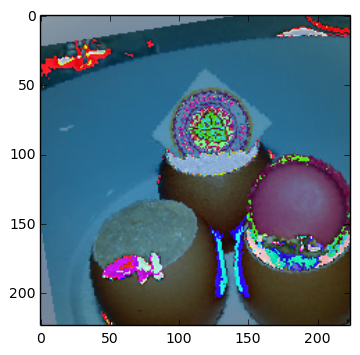

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for batch in train_processor.iterate():
    images, labels = batch

    plt.imshow(images[0].transpose((1,2,0)).astype(np.uint8))
    print np.argmax(labels[0])
    break

In [9]:
import collections
od = collections.OrderedDict(sorted(classes.items()))
i = 0
for cls, el in od.iteritems(): #print cls
    if i == 57:
        print cls
    i+=1


hummus
